# Distribución granulométrica de suelos

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/particle_size_distrib.ipynb).

Las rutinas de clasificación se basan parcialmente en la norma [ASTM ASTM D6913/D6913M-17](https://www.astm.org/d6913-04r09e01.html)

## Required modules

In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import interact, widgets, fixed

## Global configuration for plots

In [2]:
plt.style.use("default")
mpl.rcParams.update(
    {
        "font.family": "serif",  # Use the Computer modern font
        "font.serif": "cmr10",
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
pd.set_option('display.float_format', '{:.1f}'.format)


# Reading the input data

In [3]:
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)

# Tabulated input data

In [4]:
df

,Tamiz,Abertura_(mm),Retenido_(g)
0,"2 1/2""",63.5,NaN
1,"2""",50.8,NaN
2,"1 1/2""",38.1,NaN
3,"1""",25.4,NaN
4,"3/4""",19.1,NaN
5,"1/2""",12.7,0.0
6,4,4.8,0.0
7,8,2.4,3.4
8,10,2.0,1.8
9,30,0.6,42.5


## Funciones

In [5]:
def complete_table(df, total_sample_weight, washed_weight):
    df_full = df.fillna(0, inplace=False)
    washed_fines = total_sample_weight - washed_weight
    # df_full.iat[-1, df_full.columns.get_loc('Retenido_(g)')] = 3
    df_full.loc[len(df_full)-1, 'Retenido_(g)'] = df_full['Retenido_(g)'].iloc[-1] + washed_fines
    # df_full['Retenido_(g)'].iloc[-1] = df_full['Retenido_(g)'].copy().iloc[-1] + washed_fines
    total_weight = df_full['Retenido_(g)'].sum()
    df_full['Retenido_(%)'] = 100 * df_full['Retenido_(g)'] / total_weight
    df_full['Retenido_acum_(%)'] = 100 * np.cumsum(df_full['Retenido_(g)']) / total_weight
    df_full['No_retenido_(%)'] = 100 - df_full['Retenido_acum_(%)']
    return df_full

In [6]:
def plot_granulometric_curve(df, figsize=None):
    figsize = [6.5, 5.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], "-b")
    # Format
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    # ax.set_aspect("equal", anchor=None)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ".b")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    return fig

In [7]:
def get_Cc_Cu(df, hztl, D60=1, D30=1, D10=1):
    figsize = [6.5, 4.5]# if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    if D60==1 and  D30==1 and D10==1:
        label = f'Cc: -\nCu: -'
    else:
        Cu = D60/D10
        Cc = D30**2/(D60*D10)
        label = f'Cc: {Cc:.1f}\nCu: {Cu:.1f}'
    ax.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], "-b", label=label)
    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    ax.axhline(hztl, ls='--', c='k', lw='.75')
    ax.axvline(D60, ls='--', c='r', lw='1')
    ax.axvline(D30, ls='--', c='g', lw='1')
    ax.axvline(D10, ls='--', c='c', lw='1')
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ".b")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    fig.tight_layout()
    return

# Completting the table

In [8]:
df_full = complete_table(df, total_sample_weight=442.7, washed_weight=265.56)
df_full

,Tamiz,Abertura_(mm),Retenido_(g),Retenido_(%),Retenido_acum_(%),No_retenido_(%)
0,"2 1/2""",63.5,0.0,0.0,0.0,100.0
1,"2""",50.8,0.0,0.0,0.0,100.0
2,"1 1/2""",38.1,0.0,0.0,0.0,100.0
3,"1""",25.4,0.0,0.0,0.0,100.0
4,"3/4""",19.1,0.0,0.0,0.0,100.0
5,"1/2""",12.7,0.0,0.0,0.0,100.0
6,4,4.8,0.0,0.0,0.0,100.0
7,8,2.4,3.4,0.8,0.8,99.2
8,10,2.0,1.8,0.4,1.2,98.8
9,30,0.6,42.5,9.6,10.8,89.2


# Visualizing the granulometric curve

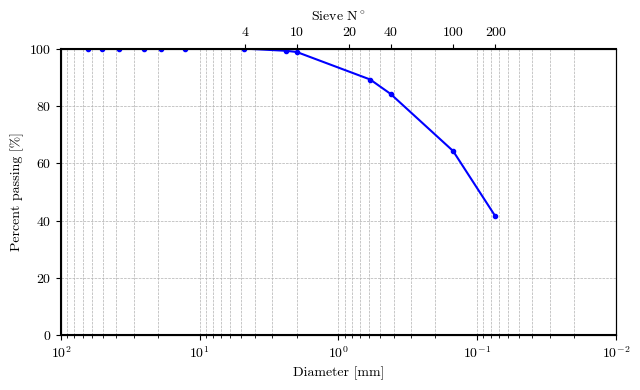

In [9]:
fig = plot_granulometric_curve(df_full, figsize=[6.5, 4])

In [11]:
# Imagen interactiva
style = {'description_width': '100px'}
interact(  # Interactive widgets
    get_Cc_Cu,
    df=fixed(df_full),
    hztl=widgets.FloatSlider(value=50, step=1, min=0, max=100, description="Auxiliar line", style=style),
    D60=widgets.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D60", style=style),
    D30=widgets.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D30", style=style),
    D10=widgets.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D10", style=style),
    )

interactive(children=(FloatSlider(value=50.0, description='Auxiliar line', step=1.0, style=SliderStyle(descrip…

<function __main__.get_Cc_Cu(df, hztl, D60=1, D30=1, D10=1)>